In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from tensorflow import keras
import keras.layers as kl
import itertools
import seaborn as sns
import plotnine as p9
import pickle
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,explained_variance_score
from sklearn.model_selection import GridSearchCV

In [3]:
ori_df_path = 'D:/ML4RG_file/genomic_sequence_plus_features_hl_all_tissues.csv'
mirna_path = 'C:/Users/yuyu/Desktop/Number_RNA_family.csv'
rbp_path = 'C:/Users/yuyu/Desktop/new_RBP_features.csv'
energy_path = 'D:/ML4RG_file/hgTables_5utr/hgTables_5utr'
site_type_path = 'C:/Users/yuyu/Desktop/result_num_site_type.csv'

df1  = pd.read_csv(ori_df_path, index_col = 0)
tissue_list = df1.columns.values[:49].tolist()

### Definie necessary functions
#### get_df(feature, relative, drop_col)
#### ridge_regression(all_tissue_df)
#### plot_result(path, feature, result_df) including scatter plots for each tissues, histogram
#### plot_heatmap(path, feature, result_df, drop)
#### compare_model_plot(list1, list2, model1, model2, path)

In [8]:
# df = original df 
# feature - list = [mirna, rbp. energy]
# tissue  - string in tissue_list
# relative - boolean =  True or False (false: absolute)
# drop - list = [columns that will be dropped]

def get_df(feature, relative, drop_col):
    df  = pd.read_csv(ori_df_path, index_col = 0)
    df = df.drop(['cds','5_utr', '3_utr', 'all'], axis = 1)
    
    if len(feature)>0:
        if 'energy' in feature:
            df = pd.read_csv(ori_df_path, index_col = False)
            df = df.drop(['cds','5_utr', '3_utr', 'all'], axis = 1)
            df.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
            df_energy = pd.read_csv(energy_path,delimiter = '\t')
            df_energy = df_energy.loc[df_energy.loc[:,['#name', 'energy']].dropna().index]
            df_energy.rename(columns = {'#name':'id'}, inplace = True)
            df_energy = df_energy.drop(['seq','fold'], axis = 1)
            df = pd.concat([df,df_energy['energy']], axis = 1, join = 'inner').set_index('id')
        if 'mirna' in feature:
            df_mirna = pd.read_csv(mirna_path,index_col = 0)
            df = pd.concat([df, df_mirna], axis=1)
        if 'rbp' in feature:
            df_rbp = pd.read_csv(rbp_path,index_col=0)
            df = pd.concat([df, df_rbp], axis=1)
        if 'site_type' in feature:
            df_site = pd.read_csv(site_type_path, index_col = 0)
            df = pd.concat([df, df_site], axis=1)
            
    # drop features' columns
    if len(drop_col)>0:
        df = df.drop(drop_col, axis=1)
    
    # calculate relative values
    if relative:    
        df['mean'] = df.loc[:, tissue_list].mean(axis=1)
        df.loc[:, tissue_list] = df.loc[:, tissue_list].sub(df['mean'], axis=0)
        df = df.drop(['mean'], axis = 1)
    
    return df

In [4]:
# return a dataframe: tissue as row, features' coefficients and scores as columns
def ridge_regression(all_tissue_df):
    #tissue_list = all_tissue_df.columns.values[:49].tolist()
    chrom_test=['chr1','chr8','chr9']

    col_list = all_tissue_df.columns.tolist()
    for i in tissue_list:
        col_list.remove(i)  
    col_list.remove('chromosome')

    result_df = pd.DataFrame()
    msqe_result = []
    evs_result = []
    pred_y = []
    test_y = []


    for tissue in tissue_list:

        df = all_tissue_df.copy()
        all_tissue = tissue_list.copy()
        all_tissue.remove(tissue)
        df = df.drop(columns = all_tissue, axis = 1) 
        df = df.loc[df.loc[:, [tissue]].dropna().index]
        df = df.fillna(0)
        

        df_tun = df.copy()  
        df_tun = df_tun.loc[df_tun.loc[:, [tissue]].dropna().index]
        df_tun = df_tun.fillna(0)
        X_tun = df_tun.drop([tissue,'chromosome'], axis=1)
        y_tun = df_tun.loc[:,tissue].values
        parameters = {'alpha':[1e-3, 1e-2, 1e-1, 1, 10]}
        model = Ridge()
        Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)
        result = Ridge_reg.fit(X_tun,y_tun)
        best_alpha = result.best_params_['alpha']  
        #best_alpha = 10
        
        # train model with best alpha
        X = df.drop(columns=[tissue])
        y = df.loc[:,tissue].values
        idx_test = np.where(df.chromosome.isin(chrom_test))[0]
        idx_train = np.where(~(df.chromosome.isin(chrom_test)))[0]
        X_train = X[~(df.chromosome.isin(chrom_test))]
        X_train = X_train.drop(['chromosome'],axis=1)
        X_test = X[df.chromosome.isin(chrom_test)]
        X_test = X_test.drop(['chromosome'],axis=1)
        y_train = y[idx_train]
        y_test = y[idx_test]
        ridge2 = Ridge(alpha = best_alpha, normalize = True)
        ridge2.fit(X_train, y_train)           
        pred2 = ridge2.predict(X_test)
        msqe = mean_squared_error(y_test,pred2,squared=False)/(abs(max(y_test)-min(y_test))/100)

        coef = pd.DataFrame(ridge2.coef_).T
        coef.columns = X_test.columns
        coef.index = [tissue]
        frames = [result_df, coef]
        result_df = pd.concat(frames)

        test_y.append(y_test)
        pred_y.append(pred2)
        msqe_result.append(msqe)
        evs_result.append(explained_variance_score(y_test, pred2)) 

    result_df['msqe'] = msqe_result
    result_df['xvar'] = evs_result
    result_df['test_y'] = test_y
    result_df['pred_y'] = pred_y
    
    return result_df
    
    

In [5]:
# path of the plot output: 
# feature name of the plot: relative/absolute mirna rbp drop ...
def plot_result(path, feature, result_df):
    xvar = result_df['xvar'].tolist()
    mse = result_df['msqe'].tolist()
    test = result_df['test_y'].tolist()
    pred = result_df['pred_y'].tolist()
    df_coef = result_df.drop(columns = ['xvar', 'msqe', 'test_y', 'pred_y'])
    
    # scatter plot for each tissue 
    if not os.path.exists(path + '/' + 'scatter_plot'):
        os.makedirs(path + '/' + 'scatter_plot')
        
    for i in range(0, len(tissue_list)):
        pred_test = {'test': test[i], 'pred': pred[i]}
        pl_df = pd.DataFrame(pred_test)
        plot = p9.ggplot(pl_df, p9.aes('test', 'pred')) + p9.geom_point(alpha=0.5) + labs(title=tissue_list[i])
        plot.save(filename = path + '/' + 'scatter_plot' + '/'+ tissue_list[i] +".jpg")
    
    # experiance variance score and msqe plots
    var = {'exp_var_sc':xvar,'tissue':tissue_list}
    m2e = {'%root_mean_sq_err':mse,'tissue':tissue_list}

    pl_var = pd.DataFrame(var)
    pl_m2e = pd.DataFrame(m2e)

    plot = p9.ggplot(pl_var, p9.aes('tissue', 'exp_var_sc')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))
    plot.save(filename=path + '/' + feature + "_exp_var_sc.jpg")

    plot1 = p9.ggplot(pl_m2e, p9.aes('tissue', '%root_mean_sq_err')) + p9.geom_col() + p9.theme(axis_text_x = p9.element_text(angle = 90))
    plot1.save(filename=path + '/' + feature + "_root_mean_sq_err.jpg")


In [159]:
# heatmap
import matplotlib.pyplot as plt
def plot_heatmap(path, feature, result_df, drop):
    df_coef = result_df.drop(columns = ['xvar', 'msqe', 'test_y', 'pred_y'])
    if len(drop)>0:
        df_coef = df_coef.drop(drop, axis=1)  
    # heatmap of coefficients
    #df_coef = df_coef.replace(to_replace=0.0, value=0.00000000001)
    coef_plot = sns.clustermap(df_coef, cmap = "RdBu_r", center=0.00, col_cluster=False, vmin = -200, vmax = 200, figsize=(15, 15),cbar_pos=(-0.05, .2, .03, .4))
    #coef_plot.ax_heatmap.set_yticklabels(coef_plot.ax_heatmap.get_ymajorticklabels(), fontsize = 3)
    coef_plot.savefig(path + '/' + feature + "_heat_coef_.jpg")
    
    #vmin = -200, vmax = 200
    

In [6]:
from adjustText import adjust_text
adjust_text_dict = {
    'expand_points': (0, 0),
}

def compare_model_plot(result_df1, result_df2, model1, model2, path, title):
    list1 = result_df1['xvar'].tolist()
    list2 = result_df2['xvar'].tolist()
    pl_dict = {model1: list1, model2: list2}

    pl_df = pd.DataFrame(pl_dict)
    pl_df['tissue'] = tissue_list

    plot = (ggplot(pl_df, aes(model1, model2, label='tissue'))
                    + geom_point(color='blue')
                    + geom_text(size= 6, adjust_text=adjust_text_dict)
                    + geom_abline()
                    + ggtitle('Explained Variance Comparison between ' + title)
                    + xlim(0,0.15)
                    + ylim(0,0.15)
                    + theme(figure_size=(11,11)) ) 
    plot.save(path + '/' + model1.split('including')[-1] + '_vs_' + model2.split('including')[-1])

### Do the regression for different models
#### we do the regression with different combinations of features
#### besides, we also do the model without codon columns

In [9]:
relative_ori_df = get_df([], True, ['TAA', 'TAG', 'TGA'])
relative_energy_df = get_df(['energy'], True, ['TAA', 'TAG', 'TGA'])
realtive_mirna_df = get_df(['mirna'], True, ['TAA', 'TAG', 'TGA'])
realtive_rbp_df = get_df(['rbp'], True, ['TAA', 'TAG', 'TGA'])
realtive_mirna_rbp_df = get_df(['mirna', 'rbp'], True, ['TAA', 'TAG', 'TGA'])
relative_mirna_enery_df = get_df(['energy','mirna'], True, ['TAA', 'TAG', 'TGA'])
relative_rbp_enery_df = get_df(['energy','rbp'], True, ['TAA', 'TAG', 'TGA'])
relative_mirna_rbp_enery_df = get_df(['energy','mirna','rbp'], True, ['TAA', 'TAG', 'TGA'])
relative_site_df = get_df('site_type', True, ['TAA', 'TAG', 'TGA'])


In [10]:
ori_result = ridge_regression(relative_ori_df)
mirna_result = ridge_regression(realtive_mirna_df)
rbp_result = ridge_regression(realtive_rbp_df)
energy_result = ridge_regression(relative_energy_df)

mirna_rbp_result = ridge_regression(realtive_mirna_rbp_df)
#mirna_energy_result = ridge_regression(relative_mirna_enery_df)
rbp_energy_result = ridge_regression(relative_rbp_enery_df)

#mirna_rbp_energy_result = ridge_regression(relative_mirna_rbp_enery_df)

#site_result = ridge_regression(relative_site_df)

### plot the results of models (later)

In [122]:
path = 'D:/ML4RG_file/Output_Figure/'
plot_result(path + 'miRNA', 'miRNA', mirna_result)
plot_result(path + 'RBP', 'RBP', mirna_result)
plot_result(path +  'miRNA+RBP', 'miRNA+RBP', mirna_rbp_result)
plot_result(path + 'miRNA+energy', 'miRNA+energy', mirna_energy_result)
plot_result(path + 'RBP+energy', 'RBP+energy', rbp_energy_result)
plot_result(path + 'miRNA+RBP+energy', 'miRNA+RBP+energy', mirna_rbp_energy_result)
plot_result(path + 'baseline', 'baseline', ori_result)
plot_result(path + 'energy', 'energy', energy_result)

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Adipose_Subcutaneous.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Adipose_Visceral_Omentum.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Adrenal_Gland.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Artery_Aorta.jpg

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Muscle_Skeletal.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Nerve_Tibial.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Ovary.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA/scatter_plot/Pancreas.jpg
D:\anaconda3\lib\site-packag

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP/scatter_plot/Brain_Putamen_basal_ganglia.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP/scatter_plot/Brain_Spinal_cord_cervical_c_1.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP/scatter_plot/Brain_Substantia_nigra.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP/scatter_plot/Br

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP/RBP_root_mean_sq_err.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Adipose_Subcutaneous.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Adipose_Visceral_Omentum.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Adrenal_Glan

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Lung.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Minor_Salivary_Gland.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Muscle_Skeletal.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP/scatter_plot/Nerve_Tibial.jpg
D

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Brain_Hippocampus.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Brain_Hypothalamus.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Brain_Nucleus_accumbens_basal_ganglia.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Thyroid.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Uterus.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Vagina.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+energy/scatter_plot/Whole_Blood.jpg
D:\anacond

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP+energy/scatter_plot/Esophagus_Muscularis.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP+energy/scatter_plot/Heart_Atrial_Appendage.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP+energy/scatter_plot/Heart_Left_Ventricle.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/RBP+energy/scat

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Brain_Caudate_basal_ganglia.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Brain_Cerebellar_Hemisphere.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Brain_Cerebellum.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Out

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Skin_Sun_Exposed_Lower_leg.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Small_Intestine_Terminal_Ileum.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/miRNA+RBP+energy/scatter_plot/Spleen.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figu

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/baseline/scatter_plot/Cells_Transformed_fibroblasts.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/baseline/scatter_plot/Colon_Sigmoid.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/baseline/scatter_plot/Colon_Transverse.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/baseline/scatter_plot/Eso

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Artery_Aorta.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Artery_Coronary.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Artery_Tibial.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Brain_Amygdala.jpg
D:\anacond

D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Pancreas.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Pituitary.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Prostate.jpg
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/energy/scatter_plot/Skin_Not_Sun_Exposed_Suprapubic.jpg
D:\anaco

### Compare explained variance of models

In [165]:
path = 'D:/ML4RG_file/Output_Figure/Compare_model'
compare_model_plot(ori_result, rbp_result, 'Explained Variance baseline', 'Explained Variance baseline including RBP', path, 'baseline and RBP')
compare_model_plot(ori_result, mirna_result, 'Explained Variance baseline', 'Explained Variance baseline including miRNA', path, 'baseline and miRNA')
compare_model_plot(ori_result, energy_result, 'Explained Variance baseline', 'Explained Variance baseline including Energy', path, 'baseline and Folding energy')

compare_model_plot(ori_result, mirna_rbp_result, 'Explained Variance baseline', 'Explained Variance baseline including miRNA and RBP', path, 'baseline and miRNA + RBP')
compare_model_plot(ori_result, rbp_energy_result, 'Explained Variance baseline', 'Explained Variance baseline including RBP and Energy', path, 'baseline and RBP + Folding energy')
compare_model_plot(ori_result, mirna_energy_result, 'Explained Variance baseline', 'Explained Variance baseline including miRNA and Energy', path, 'baseline and miRNA + Folding energy')
compare_model_plot(ori_result, mirna_rbp_energy_result, 'Explained Variance baseline', 'Explained Variance baseline including miRNA, RBP and Energy', path, 'baseline and miRNA + RBP + Folding energy')

compare_model_plot(mirna_result, mirna_rbp_result, 'Explained Variance baseline including miRNA', 'Explained Variance baseline including miRNA and RBP', path, 'miRNA and miRNA + RBP')
compare_model_plot(rbp_result, mirna_rbp_result, 'Explained Variance baseline including RBP', 'Explained Variance baseline including miRNA and RBP', path, 'RBP and miRNA + RBP')
compare_model_plot(mirna_result, mirna_energy_result, 'Explained Variance baseline including miRNA', 'Explained Variance baseline including miRNA and Energy', path, 'miRNA and miRNA + Folding energy')
compare_model_plot(rbp_result, rbp_energy_result, 'Explained Variance baseline including RBP', 'Explained Variance baseline including RBP and Energy', path, 'RBP and RBP + Folding energy')
compare_model_plot(energy_result, mirna_energy_result, 'Explained Variance baseline including Energy', 'Explained Variance baseline including miRNA and Energy', path, 'Folding energy and miRNA + Folding energy')
compare_model_plot(energy_result, rbp_energy_result, 'Explained Variance baseline including Energy', 'Explained Variance baseline including RBP and Energy', path, 'Folding energy and RBP + Folding energy')

compare_model_plot(mirna_result, rbp_result, 'Explained Variance baseline including miRNA', 'Explained Variance baseline including RBP', path, 'miRNA and RBP')
compare_model_plot(mirna_result, energy_result, 'Explained Variance baseline including miRNA', 'Explained Variance baseline including Energy', path, 'miRNA and Folding energy')
compare_model_plot(rbp_result, energy_result, 'Explained Variance baseline including RBP', 'Explained Variance baseline including Energy', path, 'RBP and Folding energy')

compare_model_plot(ori_result, site_result, 'Explained Variance baseline', 'Explained Variance baseline including site types', path, 'baseline and Site types')



D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Compare_model/Explained Variance baseline_vs_ RBP
D:\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
D:\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Compare_model/Explained Variance baseline_vs_ miRNA
D:\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
D:\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 1 rows containin

### Plot the clustering heatmap plot for coefficients of features 
#### Filter nonessential miRNA and RBP

In [124]:
base_feature = ['log_3_utr_length', 'log_5_utr_length', 'log_cds_length',
       'gc_content_5_utr', 'gc_content_cds', 'gc_content_3_utr', 'AAA', 'AAC',
       'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT',
       'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC',
       'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT',
       'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC',
       'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAC', 'TAT', 'TCA', 'TCC',
       'TCG', 'TCT', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']


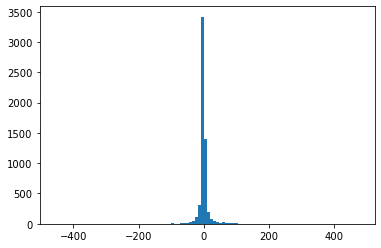

In [169]:
# find the nonessential RBP
rbp = pd.read_csv(rbp_path,index_col = 0).columns
rbp_coe_list = []
for r in rbp:
    rbp_coe_list = rbp_coe_list + rbp_result[r].tolist()


plt.hist([i for i in rbp_coe_list if abs(i)<500],bins=100)
plt.show()
#rbp_coe_list
#rbp_coe_smaller1 = []
#for r in rbp:
#    if abs(rbp_result[r]).sum()<1:
#        rbp_coe_smaller1.append(r)

In [174]:
len(rbp_coe_list)

5880

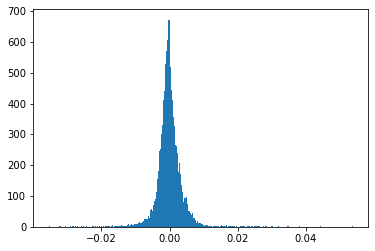

In [178]:
# find the nonessential miRNA
mirna = pd.read_csv(mirna_path,index_col = 0).columns
mirna_coe_list = []
for mi in mirna:
    mirna_coe_list = mirna_coe_list + mirna_result[mi].tolist()


plt.hist(mirna_coe_list,bins=300)
plt.show()
        

In [180]:
float(len([i for i in mirna_coe_list if i<0.05])) / float(len(mirna_coe_list))

0.9999072356215213

In [181]:
mirna_coe_important = []
for mi in mirna:
    list_mi_coef = mirna_result[mi]
    #print(mi + ' ' + 'max: ' + str(max(list_mi_coef)) + ' min: ' + str(min(list_mi_coef)))
    if float(max(list_mi_coef))> 0.05 or float(min(list_mi_coef)) < -0.05:
        mirna_coe_important.append(mi)
        
mirna_coe_smaller5 = [x for x in mirna if x not in mirna_coe_important]
        

In [182]:
len(mirna_coe_smaller5)

219

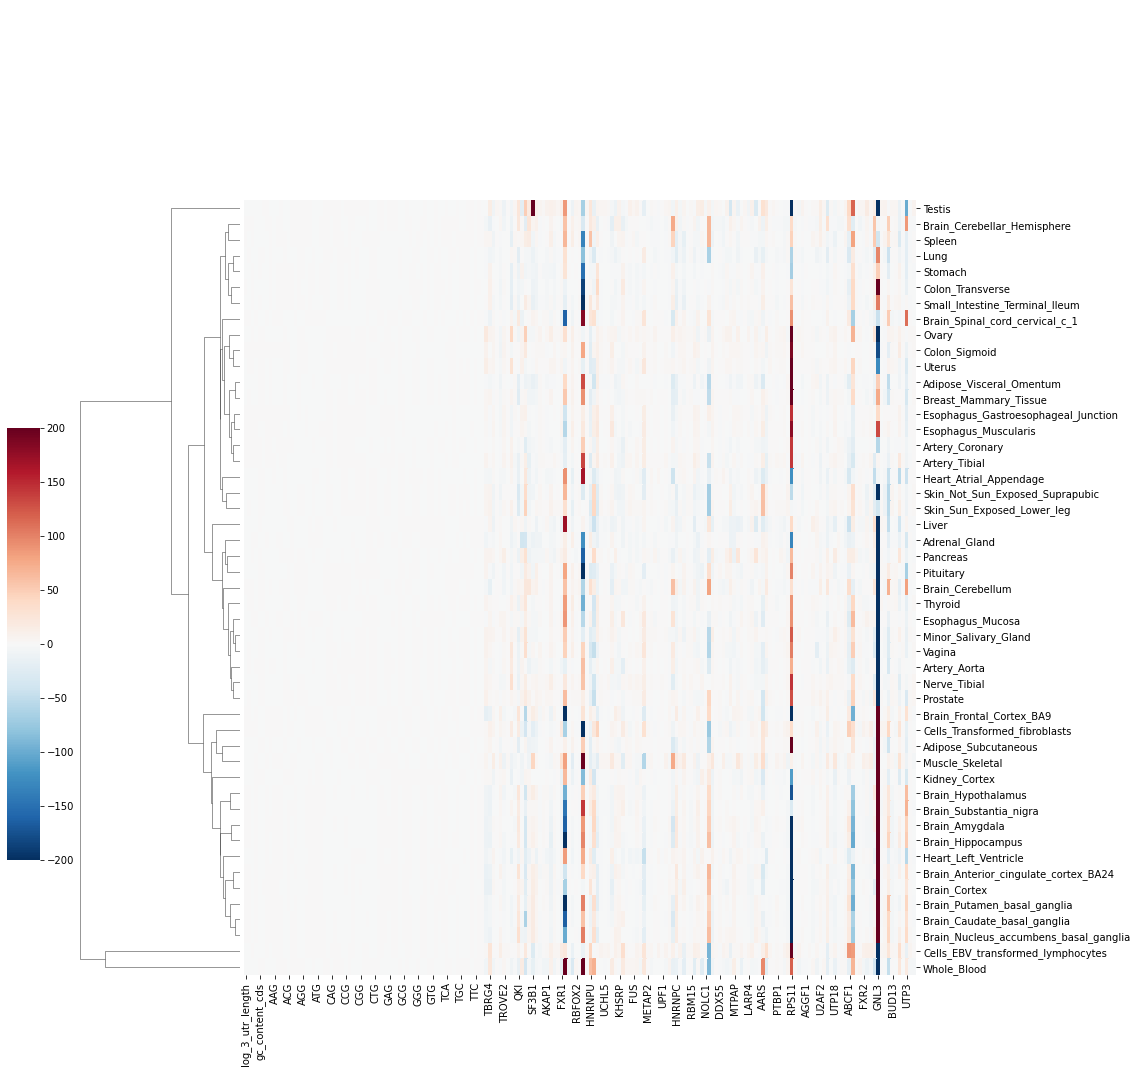

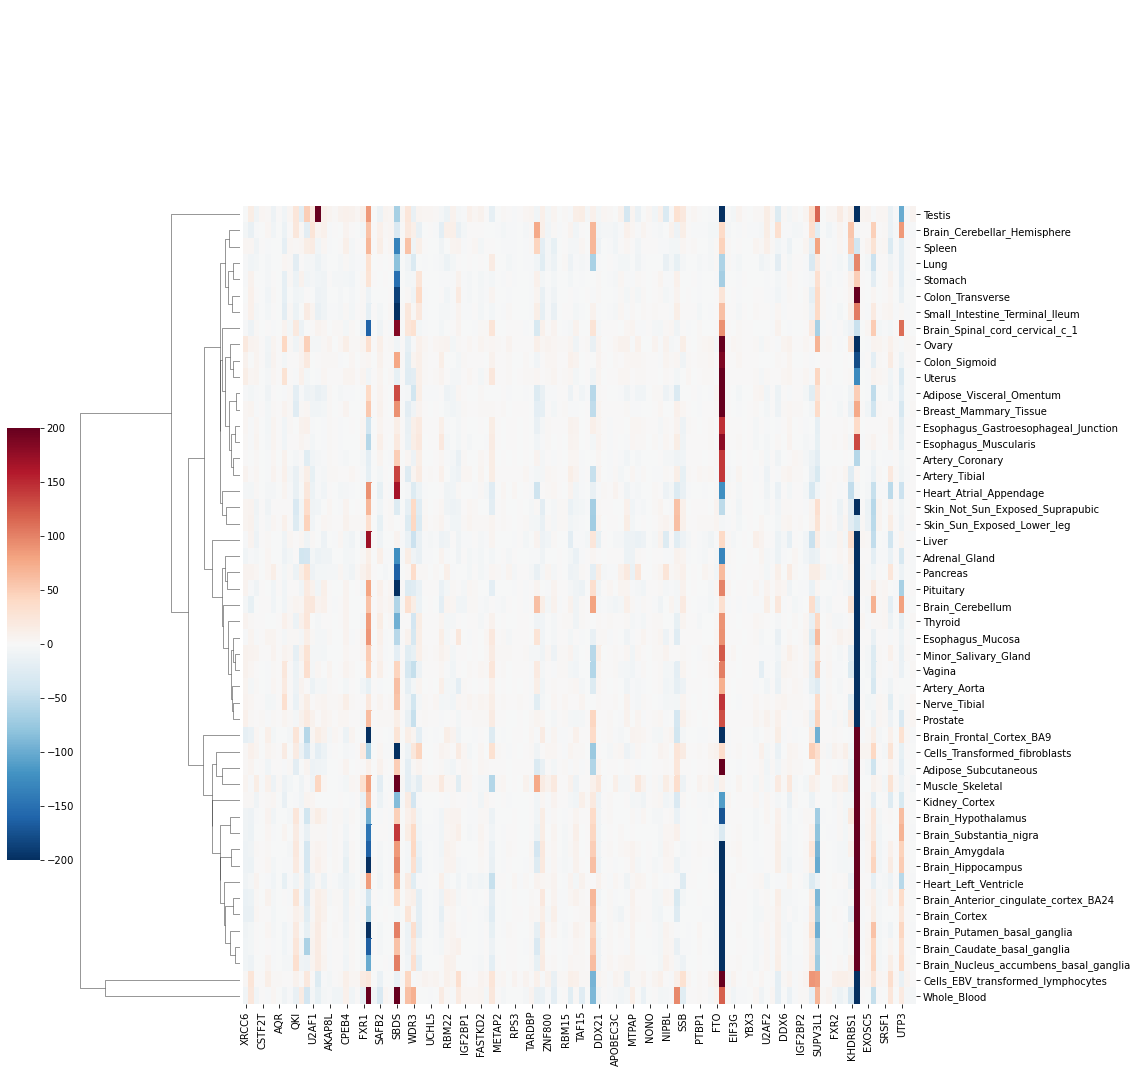

In [183]:
path = 'D:/ML4RG_file/Output_Figure/heatmap'
#plot_heatmap(path, 'Baseline', ori_result, [])
#plot_heatmap(path, 'Baseline + miRNA', mirna_result, [])
plot_heatmap(path, 'Baseline + RBP', rbp_result, [])
#plot_heatmap(path, 'Baseline + Energy', energy_result, [])
#plot_heatmap(path, 'only miRNA', mirna_result, base_feature)
plot_heatmap(path, 'only RBP', rbp_result, base_feature)
#plot_heatmap(path, 'Baseline + site_type', site_result, [])

#plot_heatmap(path, 'important miRNA + important RBP', mirna_rbp_result, base_feature + mirna_coe_smaller + rbp_coe_smaller1)
#plot_heatmap(path, 'important miRNA', mirna_result, base_feature + mirna_coe_smaller5)
#plot_heatmap(path, 'important RBP', rbp_result, base_feature + rbp_coe_smaller1)

In [57]:
# output to csv

ori_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_result.csv')
mirna_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_mirna_result.csv')
rbp_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_rbp_result.csv')
mirna_rbp_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_mirna_rbp_result.csv')
rbp_energy_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_rbp_energy.csv')
energy_result.to_csv('D:/ML4RG_file/git/RegGen2021_RNA_HL/Ridge_result_Yuyu/ridge_base_energy.csv')


## Compare ridge, lasso, multiple lasso, seq based, random forest model
### ridge, lasso, multiple lasso, and random forest: base, base_energy, base_mirna, base_rbp, base_mirna_rbp, base_rbp_energy
### seq based: 

In [68]:
from adjustText import adjust_text
adjust_text_dict = {
    'expand_points': (0, 0),
}

def compare_model2_plot(xvar1,xvar2, model1, model2, path, title):
    pl_dict = {model1: xvar1, model2: xvar2}

    pl_df = pd.DataFrame(pl_dict)
    pl_df['tissue'] = tissue_list

    plot = (ggplot(pl_df, aes(model1, model2, label='tissue'))
                    + geom_point(color='blue')
                    + geom_text(size= 6, adjust_text=adjust_text_dict)
                    + geom_abline()
                    + ggtitle('Explained Variance Comparison between ' + title)
                    + xlim(-0.05,0.15)
                    + ylim(-0.05,0.15)
                    + theme(figure_size=(11,11)) ) 
    plot.save(path + '/' + model1 + '_vs_' + model2)

In [11]:
lasso_ori_mirna = pd.read_csv('D:/ML4RG_file/lasso/lasso_base_mirna.csv', index_col = 0)
lasso_ori = pd.read_csv('D:/ML4RG_file/lasso/lasso_base.csv', index_col = 0)
lasso_ori_rbp = pd.read_csv('D:/ML4RG_file/lasso/lasso_base_rbp.csv', index_col = 0)
lasso_ori_energy = pd.read_csv('D:/ML4RG_file/lasso/lasso_base_energy.csv', index_col = 0)
lasso_ori_rbp_energy = pd.read_csv('D:/ML4RG_file/lasso/lasso_base_rbp_energy.csv', index_col = 0)
lasso_ori_rbp_mirna = pd.read_csv('D:/ML4RG_file/lasso/lasso_base_rbp_mirna.csv', index_col = 0)

multi_lasso_ori = pd.read_csv('D:/ML4RG_file/lasso/mtl_base.csv', index_col = 0)
multi_lasso_ori_rbp = pd.read_csv('D:/ML4RG_file/lasso/mtl_base_rbp.csv', index_col = 0)
multi_lasso_ori_mirna = pd.read_csv('D:/ML4RG_file/lasso/mtl_base_mirna.csv', index_col = 0)
multi_lasso_ori_energy = pd.read_csv('D:/ML4RG_file/lasso/mtl_base_energy.csv', index_col = 0)

seq_base_mirna_no_cds = pd.read_csv('D:/ML4RG_file/lasso/seq_based_base_mirna_no_cds.csv', index_col = 0)
seq_base_rbp_no_cds = pd.read_csv('D:/ML4RG_file/lasso/seq_based_base_rbp_no_cds.csv', index_col = 0)
seq_base_no_cds = pd.read_csv('D:/ML4RG_file/lasso/seq_based_base_no_cds.csv', index_col = 0)
seq_base_rbp_cds = pd.read_csv('D:/ML4RG_file/lasso/seq_based_base_rbp_with_cds.csv', index_col = 0)
seq_base_cds = pd.read_csv('D:/ML4RG_file/lasso/seq_based_base_with_cds.csv', index_col = 0)


In [62]:
xvar_ridge_ori = ori_result['xvar'].tolist()
xvar_ridge_ori_mirna = mirna_result['xvar'].tolist()
xvar_ridge_ori_rbp = rbp_result['xvar'].tolist()
xvar_ridge_ori_energy = energy_result['xvar'].tolist()
xvar_ridge_ori_mirna_rbp = mirna_rbp_result['xvar'].tolist()
xvar_ridge_ori_rbp_energy = rbp_energy_result['xvar'].tolist()

xvar_lasso_ori = lasso_ori['exp_var_sc'].tolist()
xvar_lasso_ori_mirna = lasso_ori_mirna['exp_var_sc'].tolist()
xvar_lasso_ori_rbp = lasso_ori_rbp['exp_var_sc'].tolist()
xvar_lasso_ori_energy = lasso_ori_energy['exp_var_sc'].tolist()
xvar_lasso_ori_rbp_energy = lasso_ori_rbp_energy['exp_var_sc'].tolist()
xvar_lasso_ori_rbp_mirna = lasso_ori_rbp_mirna['exp_var_sc'].tolist()

xvar_multi_lasso_ori = multi_lasso_ori['exp_var_sc'].tolist()[:-1]
xvar_multi_lasso_ori_rbp = multi_lasso_ori_rbp['exp_var_sc'].tolist()[:-1]
xvar_multi_lasso_ori_mirna = multi_lasso_ori_mirna['exp_var_sc'].tolist()[:-1]
xvar_multi_lasso_ori_energy = multi_lasso_ori_energy['exp_var_sc'].tolist()[:-1]

xvar_seq_base_no_cds = seq_base_no_cds['exp_var_score'].tolist()[:-1]
xvar_seq_base_mirna_no_cds = seq_base_mirna_no_cds['exp_var_score'].tolist()[:-1]
xvar_seq_base_rbp_no_cds = seq_base_rbp_no_cds['exp_var_score'].tolist()[:-1]
xvar_seq_base_cds = seq_base_cds['exp_var_score'].tolist()[:-1]
xvar_seq_base_rbp_cds = seq_base_rbp_cds['exp_var_score'].tolist()[:-1]

In [66]:
all_xvar_ridge = xvar_ridge_ori + xvar_ridge_ori_mirna + xvar_ridge_ori_rbp + xvar_ridge_ori_energy + xvar_ridge_ori_mirna_rbp + xvar_ridge_ori_rbp_energy
all_xvar_lasso = xvar_lasso_ori + xvar_lasso_ori_mirna + xvar_lasso_ori_rbp + xvar_lasso_ori_energy + xvar_lasso_ori_rbp_energy + xvar_lasso_ori_rbp_mirna 
all_xvar_multi_lasso = xvar_multi_lasso_ori + xvar_multi_lasso_ori_rbp + xvar_multi_lasso_ori_mirna + xvar_multi_lasso_ori_energy 
all_xvar_ridge_lasso_multi = xvar_ridge_ori + xvar_ridge_ori_mirna + xvar_ridge_ori_rbp + xvar_ridge_ori_energy + xvar_ridge_ori_mirna_rbp + xvar_ridge_ori_rbp_energy + xvar_lasso_ori + xvar_lasso_ori_mirna + xvar_lasso_ori_rbp + xvar_lasso_ori_energy + xvar_lasso_ori_rbp_energy + xvar_lasso_ori_rbp_mirna + xvar_multi_lasso_ori + xvar_multi_lasso_ori_rbp + xvar_multi_lasso_ori_mirna + xvar_multi_lasso_ori_energy 
all_xvar_seq = xvar_seq_base_no_cds + xvar_seq_base_mirna_no_cds + xvar_seq_base_rbp_no_cds + xvar_seq_base_cds + xvar_seq_base_rbp_cds    

In [67]:
max_ridge = max(all_xvar_ridge)  
min_ridge = min(all_xvar_ridge)  
print(max_ridge)
print(min_ridge)

max_lasso = max(all_xvar_lasso) 
min_lasso = min(all_xvar_lasso) 
print(max_lasso)
print(min_lasso)

max_multi = max(all_xvar_multi_lasso) 
min_multi = min(all_xvar_multi_lasso) 
print(max_multi)
print(min_multi)

max_seq = max(all_xvar_seq) 
min_seq = min(all_xvar_seq) 
print(max_seq)
print(min_seq)

0.12554239455802174
-0.03737611207118907
0.13716005689027644
-0.01576789387019728
0.12684991481786026
-0.0010647349280226148
0.1385335766210115
-0.026292787586689848


In [56]:
base_path = 'D:/ML4RG_file/Output_Figure/Comparison_All_Models'

path = base_path + '/Comparison_Ridge_Models'
compare_model2_plot(xvar_ridge_ori,xvar_ridge_ori_mirna, 'Ridge_baseline', 'Ridge_mirna', path, 'baseline model and baseline incl. miRNA ridge model')
compare_model2_plot(xvar_ridge_ori,xvar_ridge_ori_rbp, 'Ridge_baseline', 'Ridge_rbp', path, 'baseline model and baseline incl. RBP ridge model')
compare_model2_plot(xvar_ridge_ori,xvar_ridge_ori_energy, 'Ridge_baseline', 'Ridge_energy', path, 'baseline model and baseline incl. energy ridge model')

compare_model2_plot(xvar_ridge_ori,xvar_ridge_ori_mirna_rbp, 'Ridge_baseline', 'Ridge_mirna_rbp', path, 'baseline model and baseline incl. miRNA and RBP ridge model')
compare_model2_plot(xvar_ridge_ori,xvar_ridge_ori_rbp_energy, 'Ridge_baseline', 'Ridge_rbp_energy', path, 'baseline model and baseline incl. RBP and energy ridge model')
compare_model2_plot(xvar_ridge_ori_mirna,xvar_ridge_ori_mirna_rbp, 'Ridge_mirna', 'Ridge_mirna_rbp', path, 'baseline model incl. miRNA and baseline incl. miRNA and RBP ridge model')
compare_model2_plot(xvar_ridge_ori_rbp,xvar_ridge_ori_mirna_rbp, 'Ridge_rbp', 'Ridge_mirna_rbp', path, 'baseline model incl. RBP and baseline incl. miRNA and RBP ridge model')
compare_model2_plot(xvar_ridge_ori_rbp,xvar_ridge_ori_rbp_energy, 'Ridge_rbp', 'Ridge_rbp_energy', path, 'baseline model incl. RBP and baseline incl. RBP and energy ridge model')
compare_model2_plot(xvar_ridge_ori_energy,xvar_ridge_ori_rbp_energy, 'Ridge_energy', 'Ridge_rbp_energy', path, 'baseline model incl. energy and baseline incl. RBP and energy ridge model')

compare_model2_plot(xvar_ridge_ori_mirna,xvar_ridge_ori_rbp, 'Ridge_mirna', 'Ridge_rbp', path, 'baseline model incl. miRNA and baseline incl. RBP ridge model')
compare_model2_plot(xvar_ridge_ori_mirna,xvar_ridge_ori_energy, 'Ridge_mirna', 'Ridge_energy', path, 'baseline model incl. miRNA and baseline incl. energy ridge model')
compare_model2_plot(xvar_ridge_ori_rbp,xvar_ridge_ori_energy, 'Ridge_rbp', 'Ridge_energy', path, 'baseline model incl. RBP and baseline incl. energy ridge model')

path = base_path + '/Comparison_Lasso_Models'
compare_model2_plot(xvar_lasso_ori,xvar_lasso_ori_mirna, 'Lasso_baseline', 'Lasso_mirna', path, 'baseline model and baseline incl. miRNA lasso model')
compare_model2_plot(xvar_lasso_ori,xvar_lasso_ori_rbp, 'Lasso_baseline', 'Lasso_rbp', path, 'baseline model and baseline incl. RBP lasso model')
compare_model2_plot(xvar_lasso_ori,xvar_lasso_ori_energy, 'Lasso_baseline', 'Lasso_energy', path, 'baseline model and baseline incl. energy lasso model')
compare_model2_plot(xvar_lasso_ori_mirna,xvar_lasso_ori_rbp, 'Lasso_mirna', 'Lasso_rbp', path, 'baseline model incl. miRNA and baseline incl. RBP lasso model')
compare_model2_plot(xvar_lasso_ori_mirna,xvar_lasso_ori_energy, 'Lasso_mirna', 'Lasso_energy', path, 'baseline model incl. miRNA and baseline incl. energy lasso model')
compare_model2_plot(xvar_lasso_ori_rbp,xvar_lasso_ori_energy, 'Lasso_rbp', 'Lasso_energy', path, 'baseline model incl. RBP and baseline incl. energy lasso model')

compare_model2_plot(xvar_lasso_ori,xvar_lasso_ori_rbp_mirna, 'Lasso_baseline', 'Lasso_mirna_rbp', path, 'baseline model and baseline incl. miRNA and RBP lasso model')
compare_model2_plot(xvar_lasso_ori,xvar_lasso_ori_rbp_energy, 'Lasso_baseline', 'Lasso_rbp_energy', path, 'baseline model and baseline incl. RBP and energy lasso model')
compare_model2_plot(xvar_lasso_ori_mirna,xvar_lasso_ori_rbp_mirna, 'Lasso_mirna', 'Lasso_mirna_rbp', path, 'baseline model incl. miRNA and baseline incl. miRNA and RBP lasso model')
compare_model2_plot(xvar_lasso_ori_rbp,xvar_lasso_ori_rbp_mirna, 'Lasso_rbp', 'Lasso_mirna_rbp', path, 'baseline model incl. RBP and baseline incl. miRNA and RBP lasso model')
compare_model2_plot(xvar_lasso_ori_rbp,xvar_lasso_ori_rbp_energy, 'Lasso_rbp', 'Lasso_rbp_energy', path, 'baseline model incl. RBP and baseline incl. RBP and energy lasso model')
compare_model2_plot(xvar_lasso_ori_energy,xvar_lasso_ori_rbp_energy, 'Lasso_energy', 'Lasso_rbp_energy', path, 'baseline model incl. energy and baseline incl. RBP and energy lasso model')


path = base_path + '/Comparison_multiLasso_Models'
compare_model2_plot(xvar_multi_lasso_ori,xvar_multi_lasso_ori_mirna, 'Multi-Lasso_baseline', 'Multi-Lasso_mirna', path, 'baseline model and baseline incl. miRNA multi-lasso model')
compare_model2_plot(xvar_multi_lasso_ori,xvar_multi_lasso_ori_rbp, 'Multi-Lasso_baseline', 'Multi-Lasso_rbp', path, 'baseline model and baseline incl. RBP multi-lasso model')
compare_model2_plot(xvar_multi_lasso_ori,xvar_multi_lasso_ori_energy, 'Multi-Lasso_baseline', 'Multi-Lasso_energy', path, 'baseline model and baseline incl. energy multi-lasso model')
compare_model2_plot(xvar_multi_lasso_ori_mirna,xvar_multi_lasso_ori_rbp, 'Multi-Lasso_mirna', 'Multi-Lasso_rbp', path, 'baseline model incl. miRNA and baseline incl. RBP multi-lasso model')
compare_model2_plot(xvar_multi_lasso_ori_mirna,xvar_multi_lasso_ori_energy, 'Multi-Lasso_mirna', 'Multi-Lasso_energy', path, 'baseline model incl. miRNA and baseline incl. eneergy multi-lasso model')
compare_model2_plot(xvar_multi_lasso_ori_rbp,xvar_multi_lasso_ori_energy, 'Multi-Lasso_rbp', 'Multi-Lasso_energy', path, 'baseline model incl. RBP and baseline incl. energy multi-lasso model')


path = base_path + '/Comparison_Ridge_Lasso_Models'
compare_model2_plot(xvar_ridge_ori,xvar_lasso_ori, 'Ridge_baseline', 'Lasso_baseline', path, 'Ridge and lasso baseline model')
compare_model2_plot(xvar_ridge_ori_mirna,xvar_lasso_ori_mirna, 'Ridge_mirna', 'Lasso_mirna', path, 'Ridge and lasso baseline model including miRNA')
compare_model2_plot(xvar_ridge_ori_rbp,xvar_lasso_ori_rbp, 'Ridge_rbp', 'Lasso_rbp', path, 'Ridge and lasso baseline model including RBP')
compare_model2_plot(xvar_ridge_ori_energy,xvar_lasso_ori_energy, 'Ridge_energy', 'Lasso_energy', path, 'Ridge and lasso baseline model including energy')
compare_model2_plot(xvar_ridge_ori_mirna_rbp,xvar_lasso_ori_rbp_mirna, 'Ridge_mirna_rbp', 'Lasso_mirna_rbp', path, 'Ridge and lasso baseline model including miRNA and RBP')
compare_model2_plot(xvar_ridge_ori_rbp_energy,xvar_lasso_ori_rbp_energy, 'Ridge_rbp_energy', 'Lasso_rbp_energy', path, 'Ridge and lasso baseline model including RBP and energy')

path = base_path + '/Comparison_Ridge_multLasso_Models'
compare_model2_plot(xvar_ridge_ori,xvar_multi_lasso_ori, 'Ridge_baseline', 'Multi-Lasso_baseline', path, 'Ridge and Multiple Task Lasso baseline model')
compare_model2_plot(xvar_ridge_ori_mirna,xvar_multi_lasso_ori_mirna, 'Ridge_mirna', 'Multi-Lasso_mirna', path, 'Ridge and Multiple Task Lasso baseline model including miRNA')
compare_model2_plot(xvar_ridge_ori_rbp,xvar_multi_lasso_ori_rbp, 'Ridge_rbp', 'Multi-Lasso_rbp', path, 'Ridge and Multiple Task Lasso baseline model including RBP') 
compare_model2_plot(xvar_ridge_ori_energy,xvar_multi_lasso_ori_energy, 'Ridge_energy', 'Multi-Lasso_energy', path, 'Ridge and Multiple Task Lasso baseline model including energy')

path = base_path + '/Comparison_Lasso_multLasso_Models'
compare_model2_plot(xvar_lasso_ori,xvar_multi_lasso_ori, 'Lasso_baseline', 'Multi-Lasso_baseline', path, 'Lasso and Multiple Task Lasso baseline model')
compare_model2_plot(xvar_lasso_ori_mirna,xvar_multi_lasso_ori_mirna, 'Lasso_mirna', 'Multi-Lasso_mirna', path, 'Lasso and Multiple Task Lasso baseline model including miRNA')
compare_model2_plot(xvar_lasso_ori_rbp,xvar_multi_lasso_ori_rbp, 'Lasso_rbp', 'Multi-Lasso_rbp', path, 'Lasso and Multiple Task Lasso baseline model including RBP') 
compare_model2_plot(xvar_lasso_ori_energy,xvar_multi_lasso_ori_energy, 'Lasso_energy', 'Multi-Lasso_energy', path, 'Lasso and Multiple Task Lasso baseline model including energy')


D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_multiLasso_Models/Multi-Lasso_baseline_vs_Multi-Lasso_mirna
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_multiLasso_Models/Multi-Lasso_baseline_vs_Multi-Lasso_rbp
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_multiLasso_Models/Multi-Lasso_baseline_vs_Multi-Lasso_energy
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\a

In [69]:
path = base_path + '/Comparison_Seq_based_Models'
compare_model2_plot(xvar_seq_base_no_cds,xvar_seq_base_cds, 'SeqBased_noCds', 'SeqBased_Cds', path, 'Seq. based model with cds and without cds')

compare_model2_plot(xvar_seq_base_no_cds,xvar_seq_base_mirna_no_cds, 'SeqBased_noCds', 'SeqBased_mirna_noCds', path, 'Seq. based model without cds and without cds incl. miRNA')
compare_model2_plot(xvar_seq_base_no_cds,xvar_seq_base_rbp_no_cds, 'SeqBased_noCds', 'SeqBased_rbp_noCds', path, 'Seq. based model without cds and without cds incl. RBP')

compare_model2_plot(xvar_seq_base_cds,xvar_seq_base_rbp_cds, 'SeqBased_Cds', 'SeqBased_rbp_Cds', path, 'Seq. based model with cds and with cds incl. RBP')

compare_model2_plot(xvar_seq_base_rbp_no_cds,xvar_seq_base_rbp_cds, 'SeqBased_rbp_noCds', 'SeqBased_rbp_Cds', path, 'Seq. based model without cds incl. RBP and with cds incl. RBP')


D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models/SeqBased_noCds_vs_SeqBased_Cds
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models/SeqBased_noCds_vs_SeqBased_mirna_noCds
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models/SeqBased_noCds_vs_SeqBased_rbp_noCds
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-pac

In [70]:
path = base_path + '/Comparison_Seq_based_Models_others'
compare_model2_plot(xvar_seq_base_no_cds,xvar_ridge_ori, 'SeqBased_noCds', 'Ridge_baseline', path, 'Seq. based model without cds and Ridge baseline model')
compare_model2_plot(xvar_seq_base_cds,xvar_ridge_ori, 'SeqBased_Cds', 'Ridge_baseline', path, 'Seq. based model with cds and Ridge baseline model')

compare_model2_plot(xvar_seq_base_no_cds,xvar_lasso_ori, 'SeqBased_noCds', 'Lasso_baseline', path, 'Seq. based model without cds and Lasso baseline model')
compare_model2_plot(xvar_seq_base_cds,xvar_lasso_ori, 'SeqBased_Cds', 'Lasso_baseline', path, 'Seq. based model with cds and Lasso baseline model')

compare_model2_plot(xvar_seq_base_no_cds,xvar_multi_lasso_ori, 'SeqBased_noCds', 'Multi-Lasso_baseline', path, 'Seq. based model without cds and Multi-Lasso baseline model')
compare_model2_plot(xvar_seq_base_cds,xvar_multi_lasso_ori, 'SeqBased_Cds', 'Multi-Lasso_baseline', path, 'Seq. based model with cds and Multi-Lasso baseline model')

compare_model2_plot(xvar_seq_base_mirna_no_cds,xvar_ridge_ori_mirna, 'SeqBased_mirna_noCds', 'Ridge_mirna', path, 'Seq. based model without cds incl. miRNA and Ridge baseline model incl. miRNA')
compare_model2_plot(xvar_seq_base_mirna_no_cds,xvar_lasso_ori_mirna, 'SeqBased_mirna_noCds', 'Lasso_mirna', path, 'Seq. based model without cds incl. miRNA and Lasso baseline model incl. miRNA')
compare_model2_plot(xvar_seq_base_mirna_no_cds,xvar_multi_lasso_ori_mirna, 'SeqBased_mirna_noCds', 'Multi-Lasso_mirna', path, 'Seq. based model without cds incl. miRNA and Multi-Lasso baseline model incl. miRNA')


compare_model2_plot(xvar_seq_base_rbp_no_cds,xvar_ridge_ori_rbp, 'SeqBased_rbp_noCds', 'Ridge_rbp', path, 'Seq. based model without cds incl. RBP and Ridge baseline model incl. RBP')
compare_model2_plot(xvar_seq_base_rbp_no_cds,xvar_lasso_ori_rbp, 'SeqBased_rbp_noCds', 'Lasso_rbp', path, 'Seq. based model without cds incl. RBP and Lasso baseline model incl. RBP')
compare_model2_plot(xvar_seq_base_rbp_no_cds,xvar_multi_lasso_ori_rbp, 'SeqBased_rbp_noCds', 'Multi-Lasso_rbp', path, 'Seq. based model without cds incl. RBP and Multi-Lasso baseline model incl. RBP')

compare_model2_plot(xvar_seq_base_rbp_cds,xvar_ridge_ori_rbp, 'SeqBased_rbp_Cds', 'Ridge_rbp', path, 'Seq. based model with cds incl. RBP and Ridge baseline model incl. RBP')
compare_model2_plot(xvar_seq_base_rbp_cds,xvar_lasso_ori_rbp, 'SeqBased_rbp_Cds', 'Lasso_rbp', path, 'Seq. based model with cds incl. RBP and Lasso baseline model incl. RBP')
compare_model2_plot(xvar_seq_base_rbp_cds,xvar_multi_lasso_ori_rbp, 'SeqBased_rbp_Cds', 'Multi-Lasso_rbp', path, 'Seq. based model with cds incl. RBP and Multi-Lasso baseline model incl. RBP')


D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models_others/SeqBased_noCds_vs_Ridge_baseline
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models_others/SeqBased_Cds_vs_Ridge_baseline
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: D:/ML4RG_file/Output_Figure/Comparison_All_Models/Comparison_Seq_based_Models_others/SeqBased_noCds_vs_Lasso_baseline
D:\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 11 x 11 in image.
D:\anaconda3\l